<a href="https://colab.research.google.com/github/dorigonato/Sistema_de_Recomendacao/blob/main/Projeto_de_Recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Pasta principal para os produtos
os.makedirs('/content/Produtos', exist_ok=True)

# Subpastas para categorias
categorias = ['Relogios', 'Camisetas', 'Bicicletas', 'Sapatos']
for categoria in categorias:
    os.makedirs(f'/content/Produtos/{categoria}', exist_ok=True)

print("Pastas criadas com sucesso!")

Pastas criadas com sucesso!


In [ ]:
# Listando os arquivos em cada categoria
for categoria in categorias:
    print(f"\nImagens na categoria {categoria}:")
    diretorio_categoria = f'/content/Produtos/{categoria}'
    for arquivo in os.listdir(diretorio_categoria):
      if arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"- {arquivo}")


Imagens na categoria Relogios:
- relogio4.jpg
- relogio1.jpg
- relogio3.jpg
- relogio2.jpg

Imagens na categoria Camisetas:
- camiseta3.jpg
- camiseta2.jpg
- camiseta1.jpg
- camiseta4.jpg

Imagens na categoria Bicicletas:
- bike2.jpg
- bike3.jpg
- bike1.jpg
- bike4.jpg

Imagens na categoria Sapatos:
- sapato1.jpg
- sapato3.jpg
- sapato2.jpg
- sapato4.jpg


In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [ ]:
module_handle = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
model = hub.KerasLayer(module_handle, trainable=False)
IMG_SIZE = 224

In [ ]:
def preprocess_image(image_path, img_size = IMG_SIZE):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erro ao carregar imagem: {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_size, img_size))
    image = image / 255.0 #Normalizar para o modelo
    image = np.expand_dims(image, axis=0) #Adiciona dimensão do batch
    return image

def extract_features(image, model = model):
    features = model(image)
    features = np.squeeze(features)
    return features

In [ ]:
#Extraindo os vetores de características para cada imagem do dataset
dataset_features = {}
for categoria in categorias:
    print(f"\nExtraindo características da categoria: {categoria}")
    diretorio_categoria = f'/content/Produtos/{categoria}'
    for arquivo in tqdm(os.listdir(diretorio_categoria)):
        if arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(diretorio_categoria, arquivo)
            image = preprocess_image(image_path)
            if image is not None:
                features = extract_features(image)
                dataset_features[arquivo] = features

#Salvando os vetores de características em um arquivo pickle
with open('dataset_features.pkl', 'wb') as f:
    pickle.dump(dataset_features, f)
print("Vetor de características extraídas e salvas com sucesso!")


Extraindo características da categoria: Relogios


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]



Extraindo características da categoria: Camisetas


100%|██████████| 4/4 [00:00<00:00, 22.24it/s]



Extraindo características da categoria: Bicicletas


100%|██████████| 4/4 [00:00<00:00, 23.55it/s]



Extraindo características da categoria: Sapatos


100%|██████████| 4/4 [00:00<00:00, 30.14it/s]

Vetor de características extraídas e salvas com sucesso!


In [ ]:
def recommend_similar_images(image_path, top_k=4, model = model, dataset_features_path = 'dataset_features.pkl'):
    with open(dataset_features_path, 'rb') as f:
      dataset_features = pickle.load(f)
    input_image = preprocess_image(image_path)

    if input_image is None:
        print("Erro na leitura da imagem de entrada")
        return None
    input_features = extract_features(input_image)

    similarities = {}
    for filename, features in dataset_features.items():
       sim = cosine_similarity(input_features.reshape(1, -1), features.reshape(1, -1))[0][0]
       similarities[filename] = sim

    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)

    #Recomendando os top k resultados
    top_similar = sorted_similarities[1:top_k + 1]
    #Construindo a saída
    recommended_images = []
    for filename, score in top_similar:
        for categoria in categorias:
            diretorio_categoria = f'/content/Produtos/{categoria}'
            image_path = os.path.join(diretorio_categoria, filename)
            if os.path.exists(image_path):
               recommended_images.append((image_path, score))
               break
    return recommended_images

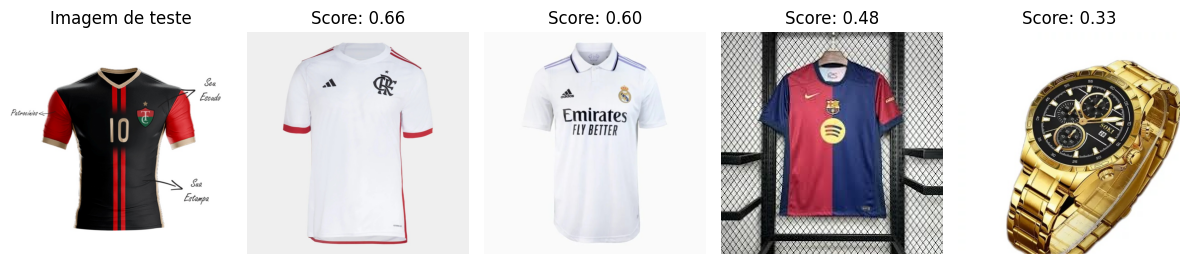

In [ ]:
test_image_path = '/content/test_image_5.jpg'
recommendations = recommend_similar_images(test_image_path)

if recommendations:
  plt.figure(figsize=(12, 6))
  plt.subplot(1, len(recommendations)+1, 1)
  plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
  plt.title("Imagem de teste")
  plt.axis('off')
  for i, (image_path, score) in enumerate(recommendations):
    plt.subplot(1, len(recommendations)+1, i + 2)
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Score: {score:.2f}')
    plt.axis('off')
  plt.tight_layout()
  plt.show()
else:
  print("Nenhuma imagem similar foi encontrada.")